In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.signal import correlate
from scipy.stats import pearsonr
import os

In [21]:
# システムパラメータ
takami_params = {
    'm1': 28.00,   # 質量1（脚）
    'm2': 53.00,   # 質量2（胴体）
    'L1': 0.90,    # 長さ1（脚）
    'L2': 0.88,    # 長さ2（胴体）
    'com1': 0.58,  # 質量中心1
    'com2': 0.32,  # 質量中心2
    'g': 9.81      # 重力加速度
}

# CoM計算関数
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # ラジアンに変換
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # CoM位置計算
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

# フォルダ内のすべてのCSVファイルを処理
def process_csv_files(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            
            # CSV読み込み
            df = pd.read_csv(file_path)
            
            # COPの微分
            df['dCOP_s'] = df['COP_s'].diff().fillna(0)
            df['ddCOP_s'] = df['dCOP_s'].diff().fillna(0)

            # CoM計算
            df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'], row['q2_s_true'], takami_params), axis=1)
            df[['dcom_x_s', 'dcom_z_s']] = df[['com_x_s', 'com_z_s']].diff().fillna(0)
            df[['ddcom_x_s', 'ddcom_z_s']] = df[['dcom_x_s', 'dcom_z_s']].diff().fillna(0)
            df[['dddcom_x_s', 'dddcom_z_s']] = df[['ddcom_x_s', 'ddcom_z_s']].diff().fillna(0)
            
            
            # 上書き保存
            df.to_csv(file_path, index=False)
            print(f"Saved: {file_path}")

# 実行（フォルダパスを指定）
folder_path = "new50withCOP"  # CSVファイルがあるフォルダのパスを設定
process_csv_files(folder_path)


Processing new50withCOP/EKF_Simulation_AllData_14.csv
Saved: new50withCOP/EKF_Simulation_AllData_14.csv
Processing new50withCOP/EKF_Simulation_AllData_28.csv
Saved: new50withCOP/EKF_Simulation_AllData_28.csv
Processing new50withCOP/EKF_Simulation_AllData_29.csv
Saved: new50withCOP/EKF_Simulation_AllData_29.csv
Processing new50withCOP/EKF_Simulation_AllData_01.csv
Saved: new50withCOP/EKF_Simulation_AllData_01.csv
Processing new50withCOP/EKF_Simulation_AllData_15.csv
Saved: new50withCOP/EKF_Simulation_AllData_15.csv
Processing new50withCOP/EKF_Simulation_AllData_03.csv
Saved: new50withCOP/EKF_Simulation_AllData_03.csv
Processing new50withCOP/EKF_Simulation_AllData_17.csv
Saved: new50withCOP/EKF_Simulation_AllData_17.csv
Processing new50withCOP/EKF_Simulation_AllData_16.csv
Saved: new50withCOP/EKF_Simulation_AllData_16.csv
Processing new50withCOP/EKF_Simulation_AllData_02.csv
Saved: new50withCOP/EKF_Simulation_AllData_02.csv
Processing new50withCOP/EKF_Simulation_AllData_06.csv
Saved: new

In [22]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr, friedmanchisquare, wilcoxon

# システムパラメータ
takami_params = {
    'm1': 28.00,   # 質量1（脚）
    'm2': 53.00,   # 質量2（胴体）
    'L1': 0.90,    # 長さ1（脚）
    'L2': 0.88,    # 長さ2（胴体）
    'com1': 0.58,  # 質量中心1
    'com2': 0.32,  # 質量中心2
    'g': 9.81      # 重力加速度
}

# CoM計算関数
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # ラジアンに変換
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # CoM位置計算
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

# フォルダ内のすべてのCSVファイルを処理し、統合
def process_csv_files(folder_path):
    all_results = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")

            # CSV読み込み
            df = pd.read_csv(file_path)
            
            # COPの微分
            df['dCOP_s'] = df['COP_s'].diff().fillna(0)
            df['ddCOP_s'] = df['dCOP_s'].diff().fillna(0)

            # CoM計算
            df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'], row['q2_s_true'], takami_params), axis=1)
            df['dcom_x_s'] = df['com_x_s'].diff().fillna(0)
            df['ddcom_x_s'] = df['dcom_x_s'].diff().fillna(0)
            df['dddcom_x_s'] = df['ddcom_x_s'].diff().fillna(0)
            
            
            # 各変数のRMS計算
            rms_values = df[['COP_s', 'dCOP_s','ddCOP_s' ,'com_x_s', 'com_z_s', 'dcom_x_s','ddcom_x_s','dddcom_x_s']].apply(lambda x: np.sqrt(np.mean(x**2)))
            all_results.append(rms_values)
    
    # すべての結果を1つのデータフレームに統合
    final_df = pd.DataFrame(all_results)
    
    # Pearsonの相関計算
    correlation_matrix = final_df.corr(method='pearson')
    print("Correlation Matrix:")
    print(correlation_matrix)
    
    return final_df, correlation_matrix

# 実行（フォルダパスを指定）
folder_path = "new50withCOP"  # CSVファイルがあるフォルダのパスを設定
final_rms_df, correlation_matrix = process_csv_files(folder_path)

# 統合データを保存
final_rms_df.to_csv("rms_summary.csv", index=False)
print("RMS summary saved as rms_summary.csv")


Processing new50withCOP/EKF_Simulation_AllData_14.csv
Processing new50withCOP/EKF_Simulation_AllData_28.csv
Processing new50withCOP/EKF_Simulation_AllData_29.csv
Processing new50withCOP/EKF_Simulation_AllData_01.csv
Processing new50withCOP/EKF_Simulation_AllData_15.csv
Processing new50withCOP/EKF_Simulation_AllData_03.csv
Processing new50withCOP/EKF_Simulation_AllData_17.csv
Processing new50withCOP/EKF_Simulation_AllData_16.csv
Processing new50withCOP/EKF_Simulation_AllData_02.csv
Processing new50withCOP/EKF_Simulation_AllData_06.csv
Processing new50withCOP/EKF_Simulation_AllData_12.csv
Processing new50withCOP/EKF_Simulation_AllData_13.csv
Processing new50withCOP/EKF_Simulation_AllData_07.csv
Processing new50withCOP/EKF_Simulation_AllData_39.csv
Processing new50withCOP/EKF_Simulation_AllData_11.csv
Processing new50withCOP/EKF_Simulation_AllData_05.csv
Processing new50withCOP/EKF_Simulation_AllData_04.csv
Processing new50withCOP/EKF_Simulation_AllData_10.csv
Processing new50withCOP/EKF_

In [23]:
correlation_matrix

,COP_s,dCOP_s,ddCOP_s,com_x_s,com_z_s,dcom_x_s,ddcom_x_s,dddcom_x_s
COP_s,1.000000,0.688673,0.603634,0.363369,-0.028715,-0.227294,-0.363539,-0.354655
dCOP_s,0.688673,1.000000,0.967941,-0.058142,0.020420,-0.316726,-0.317968,-0.325119
ddCOP_s,0.603634,0.967941,1.000000,-0.068039,0.022015,-0.261218,-0.249809,-0.265837
com_x_s,0.363369,-0.058142,-0.068039,1.000000,-0.318653,0.068308,-0.187714,-0.172956
com_z_s,-0.028715,0.020420,0.022015,-0.318653,1.000000,-0.145800,-0.082341,-0.091290
dcom_x_s,-0.227294,-0.316726,-0.261218,0.068308,-0.145800,1.000000,0.779152,0.688785
ddcom_x_s,-0.363539,-0.317968,-0.249809,-0.187714,-0.082341,0.779152,1.000000,0.984639
dddcom_x_s,-0.354655,-0.325119,-0.265837,-0.172956,-0.091290,0.688785,0.984639,1.000000


In [24]:
final_rms_df

,COP_s,dCOP_s,ddCOP_s,com_x_s,com_z_s,dcom_x_s,ddcom_x_s,dddcom_x_s
0,0.000934,0.001181,0.001991,0.000225,0.998765,0.000018,0.000025,0.000044
1,0.000916,0.001142,0.001931,0.000232,0.998765,0.000018,0.000025,0.000043
2,0.000890,0.001134,0.001929,0.000217,0.998765,0.000018,0.000025,0.000044
3,0.000911,0.001146,0.001916,0.000224,0.998765,0.000019,0.000026,0.000044
4,0.000911,0.001132,0.001918,0.000258,0.998765,0.000019,0.000026,0.000045
5,0.000888,0.001129,0.001904,0.000221,0.998765,0.000019,0.000026,0.000045
6,0.000891,0.001145,0.001919,0.000218,0.998765,0.000018,0.000026,0.000044
7,0.000908,0.001175,0.001988,0.000222,0.998765,0.000019,0.000025,0.000044
8,0.000905,0.001141,0.001928,0.000246,0.998765,0.000019,0.000025,0.000044
9,0.000908,0.001130,0.001899,0.000247,0.998765,0.000018,0.000025,0.000043


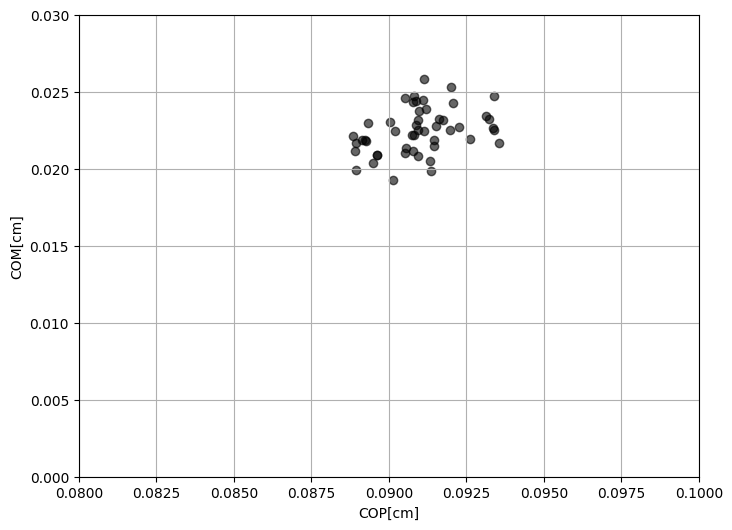

In [46]:
import matplotlib.pyplot as plt

# 単位をmからcmに変換
cop_s_cm = final_rms_df['COP_s'] * 100
com_x_s_cm = final_rms_df['com_x_s'] * 100

# 散布図を作成
plt.figure(figsize=(8, 6))
plt.scatter(cop_s_cm, com_x_s_cm,color='black', alpha=0.6)
plt.xlabel('COP[cm]')
plt.ylabel('COM[cm]')
plt.xlim(0.08,0.1 )
plt.ylim(0,0.03)
plt.grid(True)
plt.show()


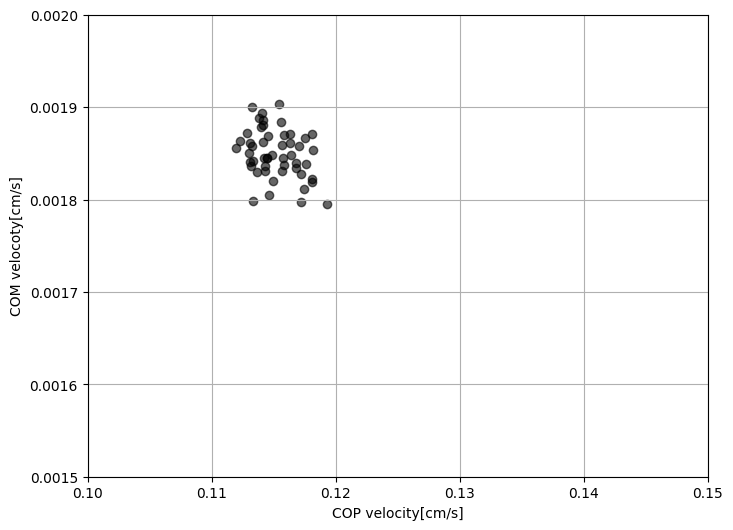

In [54]:
import matplotlib.pyplot as plt

# 単位をmからcmに変換
cop_s_cm = final_rms_df['dCOP_s'] * 100
com_x_s_cm = final_rms_df['dcom_x_s'] * 100

# 散布図を作成
plt.figure(figsize=(8, 6))
plt.scatter(cop_s_cm, com_x_s_cm,color='black', alpha=0.6)
plt.xlabel('COP velocity[cm/s]')
plt.ylabel('COM velocoty[cm/s]')
plt.xlim(0.1,0.15 )
plt.ylim(0.0015,0.002)
plt.grid(True)
plt.show()


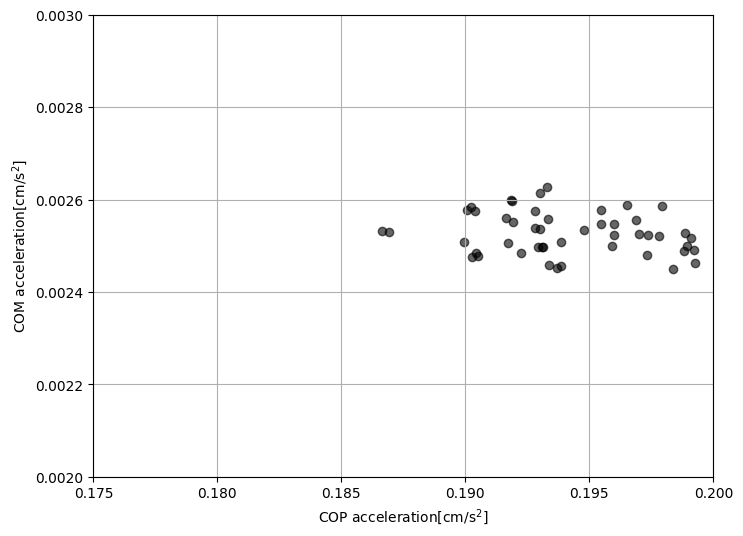

In [59]:
import matplotlib.pyplot as plt

# 単位をmからcmに変換
cop_s_cm = final_rms_df['ddCOP_s'] * 100
com_x_s_cm = final_rms_df['ddcom_x_s'] * 100

# 散布図を作成
plt.figure(figsize=(8, 6))
plt.scatter(cop_s_cm, com_x_s_cm, color='black',alpha=0.6)
# 軸ラベルを LaTeX 風の記法で修正
plt.xlabel(r'COP acceleration[cm/s$^2$]')
plt.ylabel(r'COM acceleration[cm/s$^2$]')
plt.grid(True)
plt.xlim(0.175, 0.2)
plt.ylim(0.002,0.003)
plt.show()
